# Objective

This project stimulates a real-life scenerio where the TV spending budget and product sales data of a client company were given. It aims to determine the relationship between advertising expenditures and sales and to build a simple linear regression model that predicts TV spendings based on client needs. 

# Learning Outcomes

Through the completion of the project, the following skills and concepts are demonstrated:
- Understanding of Linear Regression
    - write down later

- Use of python and application of industry-standard tools and libraries
    - Pandas and NumPy for data handling and computating
    - Matplotlib and Seaborn for data visualization and trend analysis
    - Scikit-Learn for building and evaluating regression models

- Various model interpretation and evaluation
    - Linear coefficient and intercept analysis
    - R² Score, Mean Squared Error (MSE), and residual diagnostics
    - Understanding of feature scaling and its effect on gradient descent

- Business Communications
    - Translating technical results into clear analysis to help with decision-making



# Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
from scipy import stats

from sklearn.linear_model import LinearRegression

# Data Loading and Explanation

- **Unnamed: 0**: Additional Index; Confirmed in following sections

- **TV**: Advertising Spend of TV in Thousands of Dollars

- **Sales**: Product Sell in Thousands of Dollars


In [3]:

df = pd.read_csv('Advertising.csv')
df = df.drop("Radio",axis=1)
df = df.drop("Newspaper",axis=1)
df

,Unnamed: 0,TV,Sales
0,1,230.1,22.1
1,2,44.5,10.4
2,3,17.2,9.3
3,4,151.5,18.5
4,5,180.8,12.9
...,...,...,...
195,196,38.2,7.6
196,197,94.2,9.7
197,198,177.0,12.8
198,199,283.6,25.5


# Data Visualization

A [histogram](https://www.atlassian.com/data/charts/histogram-complete-guide) is a visual representation of the distribution of quantitative data. According to [Statistics Canada](https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch9/histo/5214822-eng.htm), a histogram is "often used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form. It is also useful when dealing with large data sets (greater than 100 observations). It can help detect any unusual observations (outliers) or any gaps in the data."

[Freedman-Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) was used to determine the bin size and bin width since it calculates for the most accurate bin size that doesn't over complicate or over simplify the data. 

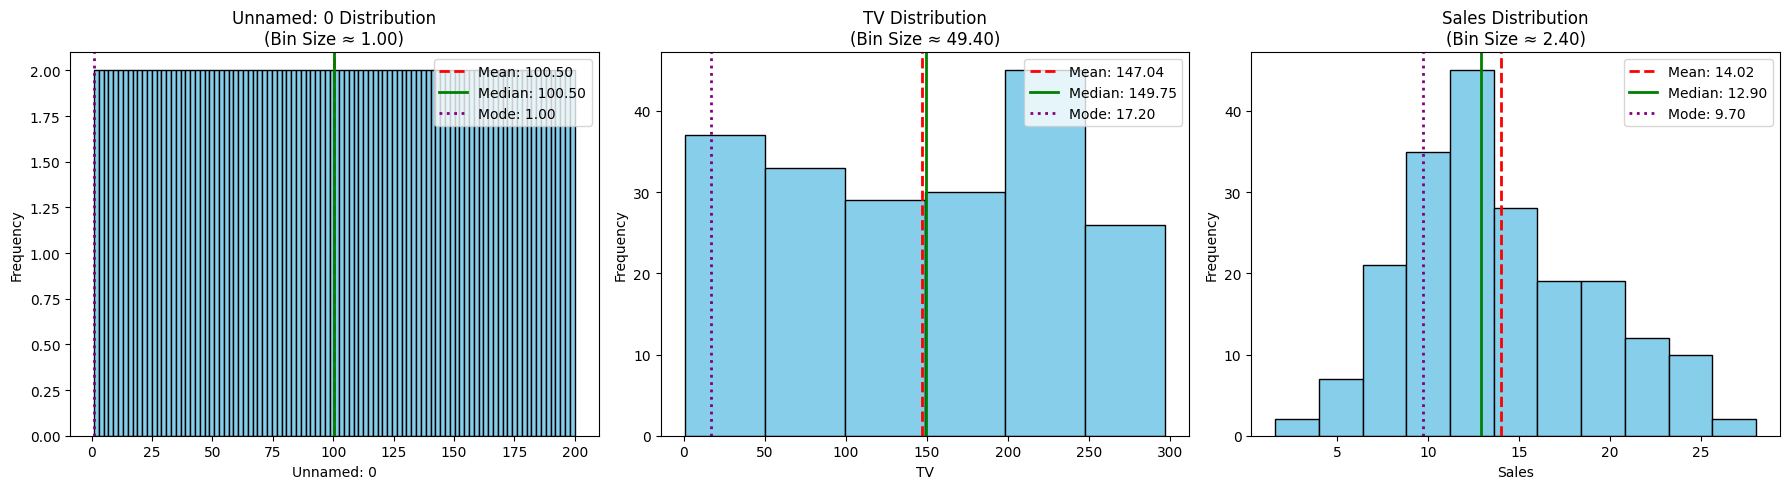

In [4]:
# Freedman–Diaconis rule function (returns bin edges and bin size)
def compute_bin_edges(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))
    if bin_width == 0:  # fallback
        bin_width = (data.max() - data.min()) / 10
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    return bins, bin_width

# draw
plt.figure(figsize=(18, 5))

for i, feature in enumerate(df.columns):

    # Calculate bin
    if i == 0:
        feature_bins = 100
        bin_width = 1
    else:
        feature_bins, bin_width = compute_bin_edges(df[feature])

    # Calculate mean, median, mode
    mean = df[feature].mean()
    median = df[feature].median()
    mode = stats.mode(df[feature], keepdims=True)[0][0]
    # TV
    plt.subplot(1, 3, i+1)
    plt.hist(df[feature], bins=feature_bins, color='skyblue', edgecolor='black')
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
    plt.axvline(mode, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode:.2f}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"{feature} Distribution\n(Bin Size ≈ {bin_width:.2f})")
    plt.legend()

plt.tight_layout()
plt.show()




In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,200.0,100.5000,57.879185,1.0,50.750,100.50,150.250,200.0
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


## Histogram Interpretation

**Unamed: 0 Distribution**: 
- plot demoonstrates uniformly flat distribution
- the mean is 100.5, and by manually calculating the mean of a list of numbers from 1-200, it can be confirmed that Unamed: 0 is a replica of the index collumn
- can be safely dropped since it is redundant

**TV Distribution**: has the highest spending (max: ~300)
- bin size 49.40
- Majority fo TV budge falls between roughly 200-250
- The distribution appears right skewed, though there are quite a number of smaller spendings as well.

**Sales Distribution**:
- Bin size of 2.4
- Histogram shows overall normal distribulation (ideal) with slight left skew
- Product sales is between 0-30
- Majority of sales falls bewteen roughly 12-14 while fewer achieves lower than 5 or higher than 25

# Data Dropping

In [6]:
df = df.drop("Unnamed: 0",axis=1)
df

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9
...,...,...
195,38.2,7.6
196,94.2,9.7
197,177.0,12.8
198,283.6,25.5


# Data Denoising

Using a scatterplot and boxplot, this. section filters the data and eliminates potential outliers with the [Interquatile Range (IQR) Method](https://en.wikipedia.org/wiki/Interquartile_range). This method calculates the lower and upper bound of the data, where anything outside of that range can be considered outliers. 

[The Interquatile Range](https://en.wikipedia.org/wiki/Interquartile_range) is the middle 50% of a set of data. It splits the data into 4 quartiles, each of 25% of the data, where Q1 is the 25% line, Q2 is the 50% line, and Q3 is the 75%. The IQR is the range including the second and third quartile, or the difference between Q3 and Q1.

The following equations show how the lower and upper bound is calcualted:

- **Lower Bound**: Q1 - 1.5*IQR

- **Lower Bound**: Q3 + 1.5*IQR

This following image explains how boxplots for in terms of representing IQR and outliers:

![box plot](https://cdn1.byjus.com/wp-content/uploads/2020/10/Box-Plot-and-Whisker-Plot-1.png)


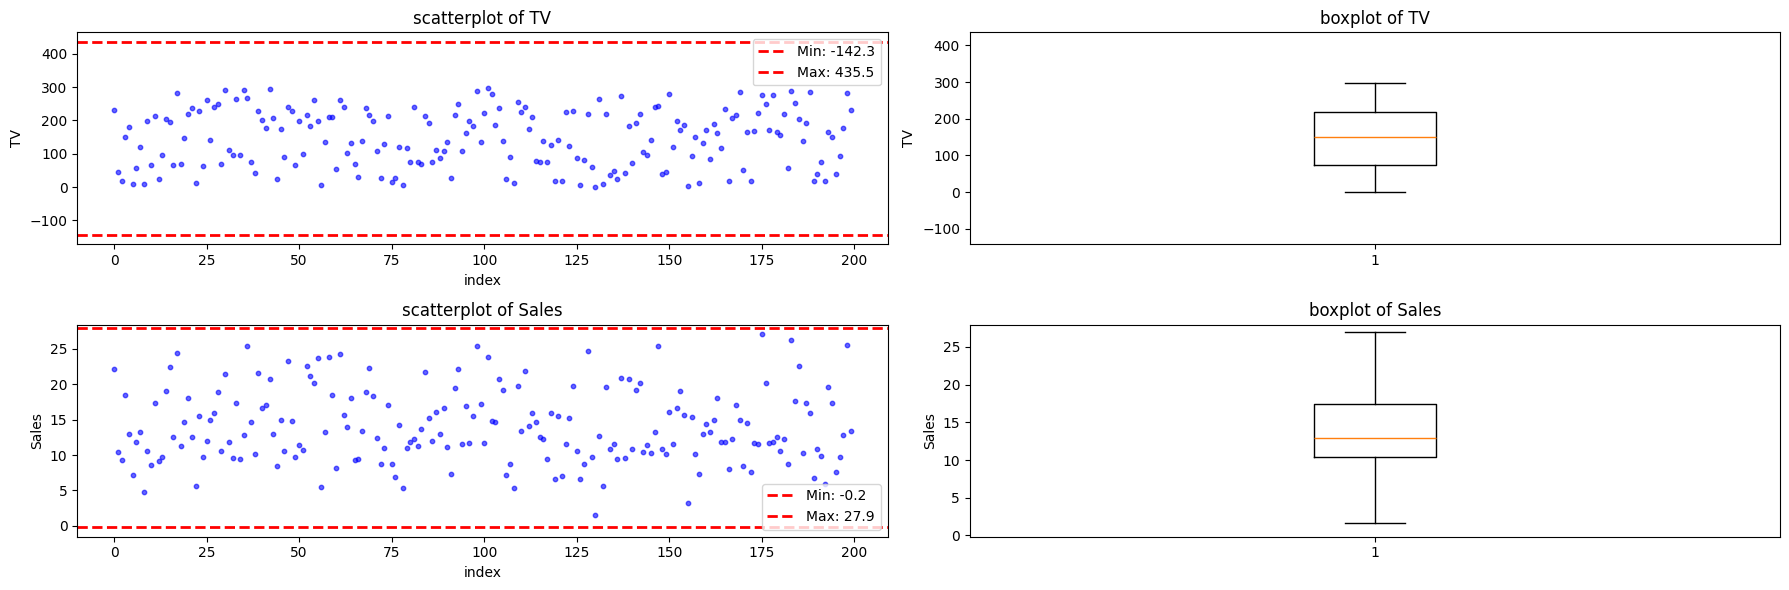

In [7]:
plt.figure(figsize=(18, 6))

for i, feature in enumerate(df.columns):
    if i == 0:
        plt.subplot(2,2,1)
    else:
        plt.subplot(2,2,3)

    # Create scatter plot
    plt.scatter(df.index, df[feature], color='blue', alpha=0.6, s = 10)

    # Add labels and title
    plt.xlabel("index")
    plt.ylabel(f"{feature}")
    plt.title(f"scatterplot of {feature}")

    #calculate IQR
    q1 = np.quantile(df[feature], 0.25)
    q3 = np.quantile(df[feature], 0.75)
    IQR = q3-q1

    #draw range
    feature_min = q1 - 1.5*IQR
    feature_max = q3 + 1.5*IQR
    plt.axhline(feature_min, color='red', linestyle='dashed', linewidth=2, label=f'Min: {feature_min:.1f}')
    plt.axhline(feature_max, color='red', linestyle='dashed', linewidth=2, label=f'Max: {feature_max:.1f}')
    plt.legend()

    #box plot
    if i == 0:
        plt.subplot(2,2,2)
    else:
        plt.subplot(2,2,4)
    plt.boxplot(df[f"{feature}"].dropna())
    plt.ylim(feature_min, feature_max) # set boundary and scale of the blox plot
    plt.ylabel(f"{feature}")
    plt.title(f"boxplot of {feature}")

# Show the plot
plt.tight_layout()
plt.show()

## IQR Interpretations

After applying IQR, it can be seen that no outliers exist with the two remaining data columns. The data is clean and ready for use. 

# Sales vs TV Spendings Correlations

This section determines the correlation between product sales and TV spendings based on a scatter plot. Since the objective is to build a prediction model for sales based on the spendings, the plot helps determine whether the data is eligible for linear regression.

The Pearson correlation coefficient, ranging from -1.0 to 1.0, describes how two variables relate to each other linearly. To use linear regression on the data set, it's important to confirm that the independant variable, TV Spendings, linearly related to the Product Sales. 

The following equation describes how the Pearson correlation coefficient (r) is calculated:

![correlation coefficient equation](https://www.simplilearn.com/ice9/free_resources_article_thumb/Pearson_Correlation_2.png)

The following images describes how the coefficient represents different linear situations:

![correlation coefficient](https://www.simplypsychology.org/wp-content/uploads/correlation-coefficient.jpg)

The following research describes what r values constitutes as a strong linear relationship.

- [Cohen’s Guidelines (1988)] (https://academic.oup.com/innovateage/article/3/4/igz036/5560156?login=false) in behavioral sciences, Jacob Cohen proposed general guidelines:
    - Small: r = 0.10
    - Medium: r = 0.30
    - Large: r = 0.50 or above

- [Mukaka (2012)](https://pmc.ncbi.nlm.nih.gov/articles/PMC3576830/) – “A guide to appropriate use of correlation coefficient in medical research”, published in Malawi Medical Journal, this article discusses similar thresholds:

    - 0.7 < r < 0.9: Strong
    - 0.9 < r < 1.0: Very strong


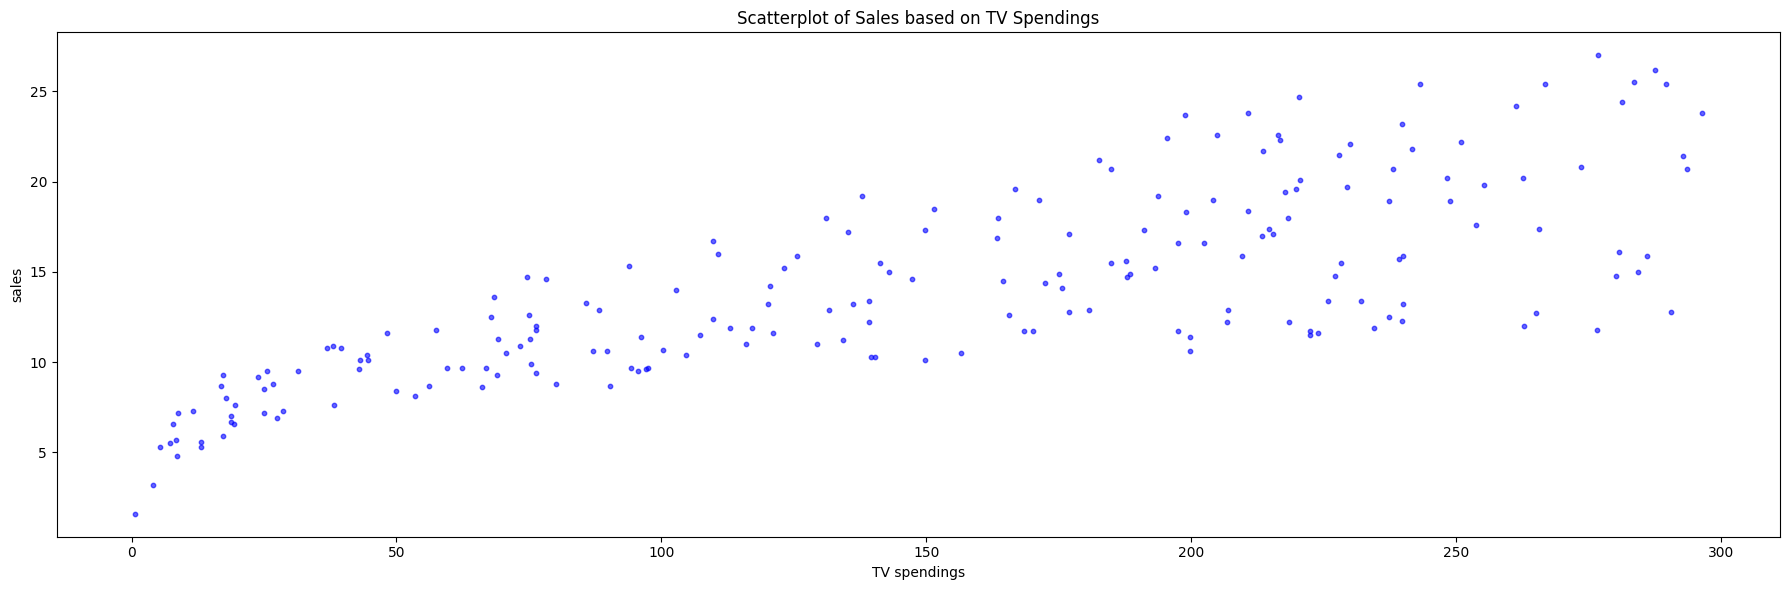

In [8]:
plt.figure(figsize=(18, 6))
# Create scatter plot
plt.scatter(df["TV"], df["Sales"], color='blue', alpha=0.6, s = 10)

# Add labels and title
plt.xlabel("TV spendings")
plt.ylabel("sales")
plt.title("Scatterplot of Sales based on TV Spendings")

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
f_corr = df["TV"].corr(df["Sales"])
print(f'{"TV"} - Sales correlation: {f_corr}')


TV - Sales correlation: 0.7822244248616066


## Correlation Interpretation

In our analysis, the correlation coefficient between TV spending and Sales is 0.7822, which is significantly larger than 0.7, indicating a strong positive relationship. TV expenditures positively relates to Product Sales. As such, linear regressio can be used for future modeling and prediction making. 

# A Simple Linear Regression

A simple linear regression line involves the following equation that models the relationship between an independant variable and predicted values of a dependant variable y: 

$ ŷ = b₀ + b₁x $

- x: independant variable (TV Spending)
- ŷ: Predicted value (Predicted Sales)
- b₀: Intercept (The Predicted Sales when TV Spending = 0)
- b₁: Slope (Rate of Change of Predicted Sales with respect to TV Spendings)

The code below manually calculates the best-fitting linear regression line for our dataset. This line can then be used to make predictions and support business decision-making. To find this best-fit line, we calculate the optimal values of b₁ and b₀ through a process called Ordinary Least Square (OLS), then minimizing the Sum of Squared Errors (SSE). 

## Calculate Most Ideal b₁ (slope), b₀ (y-intercept) and SSE with Ordinary Least Square (OLS)

The most ideal slope (b1) and intercept (b0) of the regression line equation can be calculated with [**Ordinary Least Square (OLS)**](https://www.youtube.com/watch?v=jqoHefiIf9U&t=460s). The following formulas are derived from OLS principles:

![b1 and b0 equation](https://roundtable.datascience.salon/hs-fs/hubfs/image-png-Jul-16-2024-01-06-11-0754-PM.png?width=526&height=318&name=image-png-Jul-16-2024-01-06-11-0754-PM.png)

Once we’ve computed b₁ and b₀, we can evaluate how well the regression line fits the data using the Sum of Squared Errors (SSE).

[The Sum of Squared Error](https://medium.com/exploring-the-magic-of-machine-learning/sum-of-squared-errors-sse-in-machine-learning-6ece9f2b579e) measures the overall difference between the actual data points and the predicted values from our model. A residual is the difference between an actual value y and its predicted value ŷ:

$ Residual = y - ŷ $

In our example, for each TV Spending value, we compare the actual sales to the predicted sales and calculate the square of their difference. We then repeat this for all data points and sum the squared differences. The line with the lowest SSE is considered the best fit for the data.

Here's the formula for SSE:

![SSE equation](https://cdn.corporatefinanceinstitute.com/assets/sum-of-squares3-300x120.png)

In [10]:
# numerator and denominator of beta 1
sum_n = ((df["Sales"]-df["Sales"].mean()) * (df["TV"]-df["TV"].mean())).sum() 
sum_d = (((df["TV"]-df["TV"].mean()))**2).sum()

# calculate beta1 and 0
b1_slope = (sum_n)/(sum_d)
b0_int = df["Sales"].mean() - b1_slope * df["TV"].mean()
SSE_min = np.sum((df["Sales"].values - (b1_slope * df["TV"].values + b0_int)) **2)

# print results
print(f"beta 1 (slope) = {b1_slope}")
print(f"beta 0 (intercept) = {b0_int}")
print(f"minimum sum of squared error = {SSE_min}")



beta 1 (slope) = 0.047536640433019736
beta 0 (intercept) = 7.0325935491276965
minimum sum of squared error = 2102.5305831313512


# Visualize beta 1 and beta 0

To help visualize how SSE changes based on different beta 1 and beta 0 values, the following section creates a 3D surface graph that models the relationship between the intercept, the slope, and the error. The red dot in the middle points out where the minimum SSE is located. 

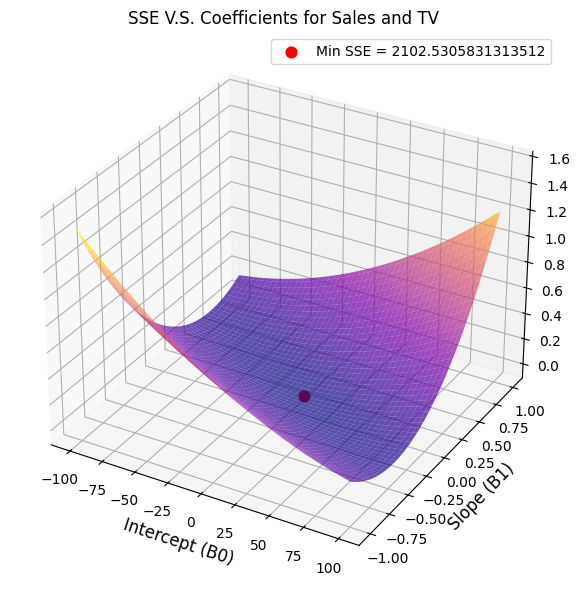

In [11]:
# define variables
x = df["TV"].values
y = df["Sales"].values

# define different axis of the 3D grid
b1_space = np.linspace(-1, 1, 100)
b0_space = np.linspace(-100, 100, 200)
b0_grid, b1_grid = np.meshgrid(b0_space, b1_space) # slope and intercept
list_of_SSE = np.zeros_like(b0_grid) 
for i in range(b0_grid.shape[0]): # calculate for SSE
    for j in range(b0_grid.shape[1]):
        sales_pred = b1_grid[i,j] * x + b0_grid[i, j]
        list_of_SSE[i, j] = np.sum((y - sales_pred) ** 2)

# draw 3D grid space
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Intercept (B0)', fontsize=12)
ax.set_ylabel('Slope (B1)', fontsize=12)
ax.set_zlabel('Sum of Squared Errors', fontsize=14, labelpad=15)
ax.set_title('SSE V.S. Coefficients for Sales and TV')

# draw 3D surface graph
ax.plot_surface(b0_grid, b1_grid, list_of_SSE, cmap='plasma', edgecolor='none',alpha=0.7)

# draw lowest SSE
ax.scatter(b0_int, b1_slope, SSE_min, color='red', s=60, label=f'Min SSE = {SSE_min}')
ax.legend()

plt.tight_layout()
plt.show()

The surface plot shows that where SSE minimizes (the darker purple region) is where the red dot is. It minimizes at around 2102.53, meaning the lowest possible error between the actual data points and the predicted data points is around 2102.53. 

# Regression Line for TV Spending v.s Sales with Different Methods

## Manual OLS
The following code visualize the regression line generated by manually imputing with OLS. As shown below, the regression line follows the general trend of the data points. 

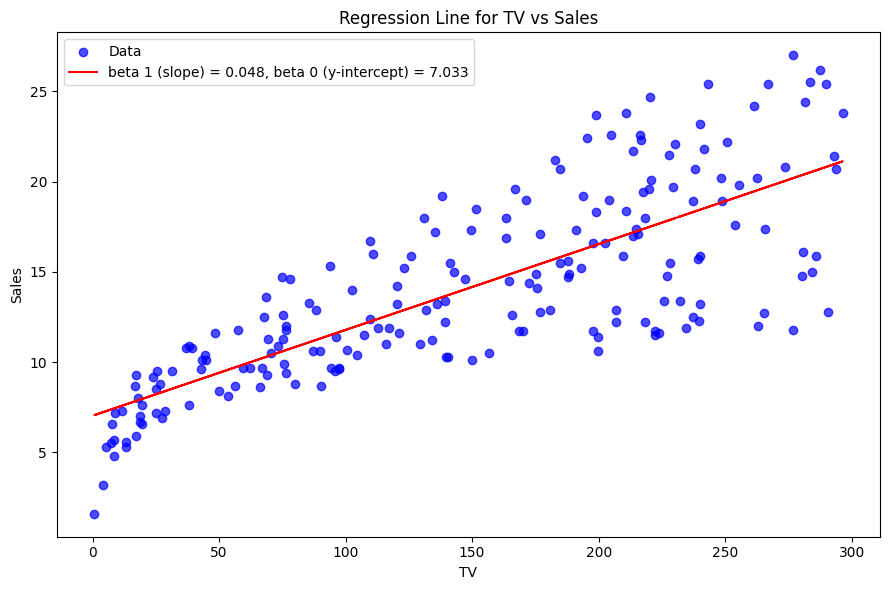

In [12]:
feature = 'TV'

plt.figure(figsize=(9, 6))
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
plt.plot(df[feature], b0_int + b1_slope  * df[feature], color='red', label=f"beta 1 (slope) = {b1_slope:.3f}, beta 0 (y-intercept) = {b0_int:.3f}")
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Gradient Descent

## NumPy
The following code visualize the regression line generated using [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), which also uses OLS. 

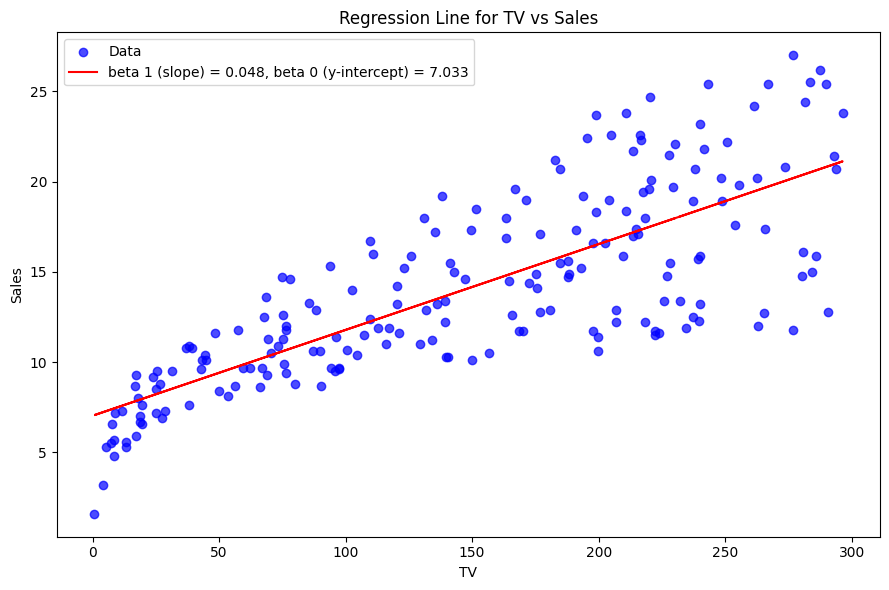

In [13]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
x = df[feature]

b1, b0 = np.polyfit(x,y,deg=1) # sovling 1st degree polynomial function (y=b1x + b0) to find b1 and b0
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
plt.plot(df[feature], b0 + b1 * df[feature], color='red', label=f"beta 1 (slope) = {b1_slope:.3f}, beta 0 (y-intercept) = {b0_int:.3f}")
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Scikit-Learning
The following code visualize the regression line generated using [Scikit-Learning](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), which also uses OLS. 

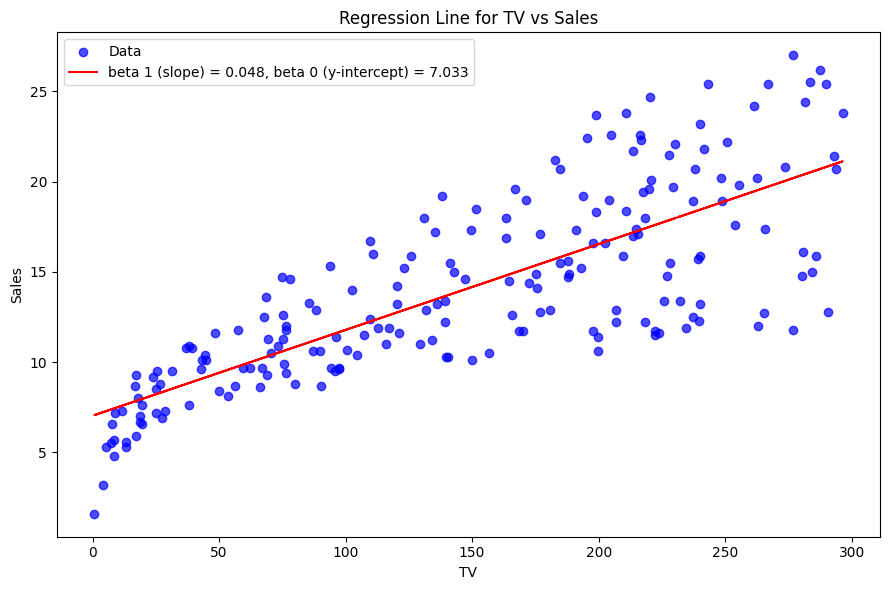

In [14]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
x = df[[feature]]  # 2D shape required for sklearn
model = LinearRegression()
model.fit(x, y) #learns pattern of dataset

b0 = model.intercept_
b1 = model.coef_[0]

y_pred = model.predict(x)

plt.scatter(df[feature], y, color='blue', label='Data', alpha=0.7)
plt.plot(df[feature], y_pred, color='red', label=f"beta 1 (slope) = {b1_slope:.3f}, beta 0 (y-intercept) = {b0_int:.3f}")
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Hypothesis Testing

The reason we need [hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_test) is because it verifies whether the slope our model predicted was due to chance and that there is an actual relationship between TV Spendings and Sales. 

- **Null Hypothesis**: Beta 1 and Beta 0 are both 0, indicating a lack of relationship between the feature and sales. 
- **Alternate Hypothesis**: Beta 1 and Beta 0 does NOT equal 0, indicating a relationship between feature and sales.

For the testing, we first need a t-distribution for both beta 1 and 0. For that happen, imagine repeatedly taking random samples of the data points and fitting a linear model to each sample to calculate a corresponding Beta 1 and Beta 0. If Null Hypothesis holds true, the beta 1 and beta 0 samples will be centered around 0 on average. With the t-distributions, we can calculate a t-value and thus a p-value from the beta 1 and beta 0 our model gave us. Then, if the values our model gave us is in the rejection region (a = 0.05), then our model is proved to show an actual relationship between TV Spendings and Sales. 

Feature: TV
b1 (Slope) = 0.0475, SE_b1 = 0.0027, t = 17.6676, p = 0.0000e+00
b0 (Intercept) = 7.0326, SE_b0 = 0.4578, t = 15.3603, p = 0.0000e+00
Slope is statistically significant (reject H0)


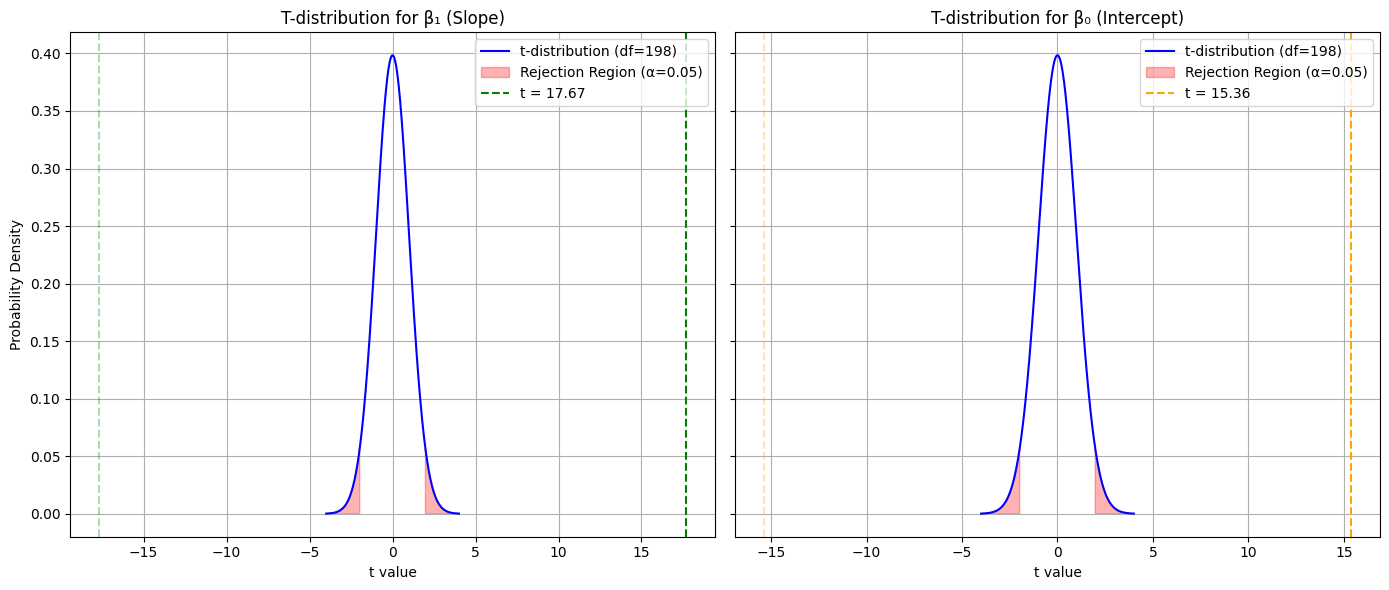

In [15]:
feature = 'TV'
y = df['Sales']
n = len(y)
dof = n - 2  # degrees of freedom

X = df[feature].values.reshape(-1, 1) # reshape feature into numpy array and 2D collumn vector

# model fitting
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

RSS = np.sum((y - y_pred) ** 2)

RSE = np.sqrt(RSS / dof) # Residual Standard Error 

# standard error
x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)

SE_b1 = RSE / np.sqrt(x_diff_sq_sum) 
SE_b0 = RSE * np.sqrt((1 / n) + (np.mean(X) ** 2 / x_diff_sq_sum)) 

# t values
b1 = model.coef_[0]
b0 = model.intercept_
t_b1 = b1 / SE_b1
t_b0 = b0 / SE_b0

# p values
p_b1 = 2 * (1 - t.cdf(np.abs(t_b1), df=dof))
p_b0 = 2 * (1 - t.cdf(np.abs(t_b0), df=dof))

# print results
print(f"Feature: {feature}")
print(f"b1 (Slope) = {b1:.4f}, SE_b1 = {SE_b1:.4f}, t = {t_b1:.4f}, p = {p_b1:.4e}")
print(f"b0 (Intercept) = {b0:.4f}, SE_b0 = {SE_b0:.4f}, t = {t_b0:.4f}, p = {p_b0:.4e}")

if p_b1 < 0.05:
    print("Slope is statistically significant (reject H0)")
else:
    print("Slope is NOT statistically significant (fail to reject H0)")

# x range and t-distribution
x = np.linspace(-4, 4, 500)
y_pdf = t.pdf(x, df=dof)
alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df=dof)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for β₁ (slope) 
axes[0].plot(x, y_pdf, label=f't-distribution (df={dof})', color='blue')
axes[0].fill_between(x, y_pdf, where=(x <= -t_crit) | (x >= t_crit), color='red', alpha=0.3, label='Rejection Region (α=0.05)')
axes[0].axvline(t_b1, color='green', linestyle='--', label=f't = {t_b1:.2f}')
axes[0].axvline(-t_b1, color='green', linestyle='--', alpha=0.3)
axes[0].set_title("T-distribution for β₁ (Slope)")
axes[0].set_xlabel("t value")
axes[0].set_ylabel("Probability Density")
axes[0].legend()
axes[0].grid(True)

# Plot for β₀ (intercept) 
axes[1].plot(x, y_pdf, label=f't-distribution (df={dof})', color='blue')
axes[1].fill_between(x, y_pdf, where=(x <= -t_crit) | (x >= t_crit), color='red', alpha=0.3, label='Rejection Region (α=0.05)')
axes[1].axvline(t_b0, color='orange', linestyle='--', label=f't = {t_b0:.2f}')
axes[1].axvline(-t_b0, color='orange', linestyle='--', alpha=0.3)
axes[1].set_title("T-distribution for β₀ (Intercept)")
axes[1].set_xlabel("t value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

As shown above, our model's predicted t-value is inside the rejection region and way higher than the critical t-value. This indicates that the slope our model provided is indeed statistically significant. 

# Confidence Interval

[The confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) is a range of values, calculated from sample data, that is likely to contain the true value of an unknown population parameter. A 95% confidence interval has the following interpretation:

If we were to repeatedly take samples and compute the confidence interval for each sample, approximately 95% of those intervals would contain the true value of the parameter. In our project regarding linear regression, we are often interested in constructing 95% confidence intervals for b₀(intercept) and b₁(slope).

- $ b₀ ± 2 * SE(b₀) $
- $ b₁ ± 2 * SE(b₁) $

That means there is approximately a 95% chance that the intervals below will contain the true value of b0 or b1, respectively.

- $ [b₀ - 2 * SE(b₀),  b₀ + 2 * SE(b₀)] $
- $ [b₁ - 2 * SE(b₁),  b₁ + 2 * SE(b₁)] $

Below is a picture for visualization: 

![confidence interval](https://www.appinio.com/hs-fs/hubfs/Confidence%20Interval%20Appinio.png?width=1024&height=768&name=Confidence%20Interval%20Appinio.png)

In [16]:
feature = 'TV'
x = df[feature]
y = df['Sales']
x_mean = x.mean()
y_mean = y.mean()

x_diff = x - x_mean
y_diff = y - y_mean

B1 = (x_diff * y_diff).sum() / (x_diff ** 2).sum()
B0 = y_mean - B1 * x_mean

# Confidence Interval（about 95%）
B1_low, B1_high = B1 - 2 * SE_b1, B1 + 2 * SE_b1
B0_low, B0_high = B0 - 2 * SE_b0, B0 + 2 * SE_b0

print(f"Feature: {feature}")
print(f"  Slope (B1): {B1:.4f}, Intercept (B0): {B0:.4f}")
print(f"  SE of B1: {SE_b1:.4f}, SE of B0: {SE_b0:.4f}")
print(f"  B1 range: [{B1_low:.4f}, {B1_high:.4f}]")
print(f"  B0 range: [{B0_low:.4f}, {B0_high:.4f}]")

Feature: TV
  Slope (B1): 0.0475, Intercept (B0): 7.0326
  SE of B1: 0.0027, SE of B0: 0.4578
  B1 range: [0.0422, 0.0529]
  B0 range: [6.1169, 7.9483]


We found that the 95% interval of b1 and b0 are respectively [0.0422, 0.0529] and [6.1169, 7.9483]. That means that: 

- Without any advertising, sales will, on average, range between \$6116.90 to \$7948.3.
- With every \$1000 increase in TV advertising expenditure, sales increased between \$42.2 to \$52.90. 